# Install

In [1]:
!pip install -q numpy pandas rdkit mendeleev torch torchvision transformers scikit-learn pytorch-lightning matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.4/367.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 45.6 MB/s eta 0:00:00


In [2]:
# 코랩 - 구글 드라이브 연결
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import random
import warnings

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import (
    Descriptors,
    rdMolDescriptors,
    MolFromSmiles
)
from mendeleev.fetch import fetch_table

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# 데이터셋 경로 설정
ROOT_DIR_GOOGLEDRIVE = '/content/drive/MyDrive/Contest/New-Medinine-Dev/'
ROOT_DIR_LOCAL = '..'

In [5]:
# 난수 설정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [6]:
# 시각화 모듈 관련 설정
warnings.filterwarnings('ignore')           # 출력 창 경고 메시지 무시
plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 음수부호 깨짐 관련
plt.rcParams['font.family'] = 'sans-serif'
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.font_manager')

---

# 피처 추출

In [69]:
class ChemicalFeatureGenerator():
    """
    ChemBERT 모델을 사용하여 임베딩 벡터와 RDKit 피처를 생성하는 클래스.
    """
    def __init__(self, chembert_model: str) -> None:
        # Mendeleev 테이블에서 원자 특성 데이터를 가져옴
        self.mendeleev_atomic_f_table = fetch_table('elements')[[
            'atomic_radius', 'atomic_radius_rahm', 'atomic_volume', 'atomic_weight', 'c6', 'c6_gb',
            'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double',
            'covalent_radius_pyykko_triple', 'density', 'dipole_polarizability', 'dipole_polarizability_unc',
            'electron_affinity', 'en_allen', 'en_ghosh', 'en_pauling', 'heat_of_formation', 'is_radioactive',
            'molar_heat_capacity', 'specific_heat_capacity', 'vdw_radius'
        ]]
        # ChemBERT 모델의 토크나이저 초기화
        self.tokenizer = AutoTokenizer.from_pretrained(chembert_model)

    def get_atomic_features(self, atom: Chem.Atom) -> tuple:
        """
        RDKit을 사용하여 원자 특징관련 피처를 추출하는 함수.
        """
        atomic_num = atom.GetAtomicNum() - 1 # Mendeleev 테이블의 인덱스는 0부터 시작하므로 -1
        mendel_atom_f = np.array(self.mendeleev_atomic_f_table.loc[atomic_num].to_numpy().astype(np.float32))

        # RDKit 원자 피처 추출
        rdkit_atom_f = np.array([
            atom.GetDegree(), atom.GetTotalDegree(), atom.GetFormalCharge(),
            atom.GetIsAromatic() * 1., atom.GetNumImplicitHs(), atom.GetNumExplicitHs(),
            atom.GetTotalNumHs(), atom.GetNumRadicalElectrons(), atom.GetImplicitValence(),
            atom.GetExplicitValence(), atom.GetTotalValence(), atom.IsInRing() * 1.
        ], dtype=np.float32)
        return mendel_atom_f, rdkit_atom_f

    def get_molecular_features(self, mol: Chem.Mol) -> list:
        """
        RDKit을 사용하여 분자의 다양한 피처를 추출하는 함수.
        pIC50과 상관관계가 높은 5가지 피처와 특정 화학 그룹의 개수를 추출.
        """
        return [
            # pIC50 상관관계 0.45이상 피처 5개
            Descriptors.Chi0(mol),
            Descriptors.Chi0n(mol),
            Descriptors.Chi2n(mol),
            Descriptors.Kappa1(mol),
            Descriptors.fr_pyridine(mol),

            # 특정 화학그룹 존재 유무
            len(mol.GetSubstructMatches(MolFromSmiles("[C](=O)[OH]"))),     # Carboxyl(산성) 그룹(수소 결합 수용체 및 공여체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[NH2]"))),           # Amine(염기) 그룹(수소 결합 공여체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[NH4+]"))),          # Ammonium(양전하 이온) 그룹(강한 수소 결합 공여체, 이온 결합) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[S](=O)(=O)[O-]"))), # Sulfonic Acid(강한 산성 작용기) 그룹(수소 결합 수용체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles('CO')))               # Alkoxy(에터구조) 그룹(수소 결합 수용체) 개수
        ]

    def encoder_smiles(self, smiles: str) -> torch.Tensor:
        """
        SMILES 문자열을 ChemBERT 모델에 입력할 수 있도록 토큰화하고 텐서 형식으로 변환.
        """
        inputs = self.tokenizer.encode_plus(smiles, padding=True, return_tensors='pt', add_special_tokens=True)
        return inputs['input_ids']

In [70]:
class ChemicalDataset(Dataset):
    """
    PyTorch Dataset 클래스를 확장하여 화학 데이터를 다루는 데이터셋 클래스.
    """
    def __init__(
        self,
        dataframe: pd.DataFrame,
        mol_features: np.array,
        atomic_features: np.array,
        feature_generator,
        is_train = True
    ):
        super().__init__()
        self.df = dataframe
        self.mol_features = mol_features
        self.atomic_features = atomic_features
        self.feature_generator = feature_generator
        self.is_train = is_train

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> tuple:
        """
        데이터셋에서 특정 인덱스의 샘플을 가져오는 함수.
        """
        sample = self.df.iloc[idx]
        molecular_feature = self.mol_features[idx]
        atomic_feature = self.atomic_features[idx]
        smiles = sample['Smiles']
        input_ids = self.feature_generator.encoder_smiles(smiles)  # ChemBERT 임베딩

        # combined_features로 통합
        combined_features = np.concatenate((molecular_feature, atomic_feature), axis=-1)

        # 라벨 값 설정
        label = sample['pIC50'] if self.is_train else -99.

        # 텐서로 변환
        combined_features = torch.tensor(combined_features, dtype=torch.float).view(1, -1)
        label = torch.tensor(label, dtype=torch.float).view(1, -1)

        return input_ids, combined_features, label

In [71]:
class KFoldDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning을 사용한 K-Fold 데이터 모듈 클래스.
    """
    def __init__(
        self,
        train_df: str,
        feature_generator: ChemicalFeatureGenerator,
        k_idx: int = 1,
        num_splits: int = 5,
        batch_size: int = 32,
        seed: int = 42
    ):
        super().__init__()
        self.train_df = train_df
        self.feature_generator = feature_generator
        self.k_idx = k_idx
        self.num_splits = num_splits
        self.batch_size = batch_size
        self.seed = seed
        self.train_data = None
        self.val_data = None

    def setup(self, stage: str = None) -> None:
        """
        데이터셋 설정 및 구성 함수.
        """
        df = pd.read_csv(self.train_df)

        # RDKit 피처 생성
        mol_features = []
        atomic_features = []  # 원자 피처 저장용 리스트
        for smiles in df['Smiles']:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mol_features.append(self.feature_generator.get_molecular_features(mol))

                # 각 원자에 대해 피처 생성 후 평균화하여 분자 레벨 피처로 저장
                atomic_features_per_mol = []
                for atom in mol.GetAtoms():
                    mendel_atom_f, rdkit_atom_f = self.feature_generator.get_atomic_features(atom)
                    atomic_features_per_mol.append(np.concatenate([mendel_atom_f, rdkit_atom_f]))
                atomic_features.append(np.mean(atomic_features_per_mol, axis=0))  # 원자 피처 평균값 계산

        mol_features = np.array(mol_features)
        atomic_features = np.array(atomic_features)

        # 피처 스케일링
        mol_scaler = StandardScaler()
        atomic_scaler = StandardScaler()
        mol_features = mol_scaler.fit_transform(mol_features)
        atomic_features = atomic_scaler.fit_transform(atomic_features)

        # K-Fold 데이터 분할
        kf = KFold(n_splits=self.num_splits, shuffle=True, random_state=self.seed)
        train_idx, val_idx = list(kf.split(df))[self.k_idx]

        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        self.train_data = ChemicalDataset(
            dataframe=train_df,
            mol_features=mol_features[train_idx],
            atomic_features=atomic_features[train_idx],  # atomic_features 인수 추가
            feature_generator=self.feature_generator,
            is_train=True
        )
        self.val_data = ChemicalDataset(
            dataframe=val_df,
            mol_features=mol_features[val_idx],
            atomic_features=atomic_features[val_idx],  # atomic_features 인수 추가
            feature_generator=self.feature_generator,
            is_train=True
        )

    def train_dataloader(self) -> DataLoader:
        """
        학습 데이터셋 로더를 반환하는 함수.
        """
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.custom_collate_fn)

    def val_dataloader(self) -> DataLoader:
        """
        검증 데이터셋 로더를 반환하는 함수.
        """
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.custom_collate_fn)

    @staticmethod
    def custom_collate_fn(batch):
        """
        DataLoader에서 각 샘플의 크기를 맞추기 위한 collate 함수.
        """
        input_ids, combined_features, labels = zip(*batch)

        # input_ids를 패딩하여 같은 길이로 맞추기
        input_ids = [x.squeeze(0) for x in input_ids]  # 각 텐서의 배치 차원 제거
        input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)

        # combined_features는 동일한 크기여야 함
        combined_features = torch.stack(combined_features, dim=0)

        # labels를 스택
        labels = torch.stack(labels, dim=0)

        return input_ids_padded, combined_features, labels

In [72]:
class SimplifiedMLPRegressor(nn.Module):
    '''
    ChemBERT 임베딩과 RDKit 피처, 원자 피처를 결합하여 회귀 예측을 수행하는 다층 퍼셉트론(MLP) 모델
    '''
    def __init__(
        self,
        chembert_model: str, # 허깅페이스 ChemBERT 모델 이름
        chembert_dim: int,   # ChemBERT 임베딩 차원
        combined_dim: int,   # RDKit 피처 및 원자 피처 결합 차원
        hidden_dim: int,     # MLP hidden 차원
        output_dim: int,     # 출력 차원 (pIC50 예측)
        dropout_rate: float  # Dropout 비율
    ):
        super(SimplifiedMLPRegressor, self).__init__()
        self.chembert_model = AutoModel.from_pretrained(chembert_model) # ChemBERT 모델 로드
        self.chembert_proj = nn.Linear(chembert_dim, hidden_dim) # ChemBERT 임베딩 차원을 hidden_dim으로 변환
        self.combined_proj = nn.Linear(combined_dim, hidden_dim) # RDKit 및 원자 피처 차원을 hidden_dim으로 변환

        # MLP 레이어 1
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)
        self.drop1 = nn.Dropout(dropout_rate)

        # MLP 레이어 2 (hidden_dim을 절반으로 축소)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.drop2 = nn.Dropout(dropout_rate)

        # 추가 레이어
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        self.drop3 = nn.Dropout(dropout_rate)

        # 최종 출력 레이어
        self.out = nn.Linear(hidden_dim // 2, output_dim)

        # LeakyReLU 활성화 함수 사용
        self.relu = nn.LeakyReLU(0.1)


    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        combined_features: torch.Tensor
    ) -> torch.Tensor:

        chembert_output = self.chembert_model(input_ids=input_ids, attention_mask=attention_mask) # ChemBERT 임베딩 추출
        chembert_embedding = chembert_output.last_hidden_state[:, 0, :]  # [CLS] 토큰 임베딩 추출 (batch_size, chembert_dim)
        chembert_proj = self.chembert_proj(chembert_embedding)  # ChemBERT 임베딩을 hidden_dim 크기로 변환 (batch_size, hidden_dim)

        combined_proj = self.combined_proj(combined_features)  # RDKit 및 원자 피처를 hidden_dim 크기로 변환 (batch_size, hidden_dim)
        combined_input = torch.cat([chembert_proj, combined_proj], dim=1)  # ChemBERT 임베딩과 결합된 피처 결합 (batch_size, hidden_dim * 2)

        # 첫 번째 MLP 레이어
        x = self.fc1(combined_input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)

        # 두 번째 MLP 레이어
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)

        # 세 번째 MLP 레이어
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.drop3(x)

        # 최종 출력
        output = self.out(x)
        return output

In [73]:
# pIC50에서 IC50을 계산하는 함수
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Normalized RMSE를 계산하는 함수
def calculate_normalized_rmse(true_pIC50, predicted_pIC50):
    """
    Normalized RMSE 계산.
    Normalized RMSE = RMSE / (max(true_IC50) - min(true_IC50))
    """
    # RMSE 계산
    mse = mean_squared_error(pIC50_to_IC50(true_pIC50), pIC50_to_IC50(predicted_pIC50))
    rmse = np.sqrt(mse)
    # Normalized RMSE 계산
    norm_rmse = rmse / (np.max(pIC50_to_IC50(true_pIC50)) - np.min(pIC50_to_IC50(predicted_pIC50)))
    return norm_rmse

# pIC50에서 Correct Ratio를 계산하는 함수
def calculate_correct_ratio(true_pIC50, predicted_pIC50):
    """
    Correct Ratio 계산.
    Correct Ratio = 1/N * Σ I(Absolute Error <= 0.5)
    """
    # 절대 오차 계산
    abs_errors = np.abs(predicted_pIC50 - true_pIC50)
    # 절대 오차가 0.5 이하인 경우의 수 계산
    correct_count = np.sum(abs_errors <= 0.5)
    # Correct Ratio 계산
    correct_ratio = correct_count / len(true_pIC50)
    return correct_ratio

# 최종 Score를 계산하는 함수
def calculate_score(true_pIC50, predicted_pIC50):
    """
    주어진 실제 IC50 값과 예측 IC50 값을 기반으로 Score 계산.
    Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    """
    # Normalized RMSE 계산 (A 값)
    norm_rmse = calculate_normalized_rmse(true_pIC50, predicted_pIC50)

    # Correct Ratio 계산 (B 값)
    correct_ratio = calculate_correct_ratio(true_pIC50, predicted_pIC50)

    # 최종 Score 계산
    # Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    score = 0.5 * (1 - min(norm_rmse, 1)) + 0.5 * correct_ratio

    return score

In [74]:
import torch.optim as optim

def plot_loss_curve(train_losses, val_losses):
    """
    학습 및 검증 곡선을 그리는 함수
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

# def rmse_loss(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#     """
#     Root Mean Squared Error (RMSE) 손실 함수.
#     """
#     return torch.sqrt(F.mse_loss(output, target))

# EarlyStopping 콜백 설정
early_stopping_callback = EarlyStopping(
    monitor='val_loss',   # 모니터링할 검증 지표
    patience=10,           # 개선이 없을 때 멈추기 전 대기할 에폭 수
    verbose=True,         # 로그 출력
    mode='min'            # 최소화를 목표로 하는 지표일 경우 'min', 최대화를 목표로 하는 경우 'max'
)


def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 500,
    lr: float = 0.0003,
    patience: int = 10
) -> nn.Module:

    """
    MLP 모델을 학습하고 검증 데이터를 사용하여 평가하는 함수.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3, verbose=True)

    train_losses = []
    val_losses = []
    est_val_loss = float('inf')
    patience_counter = 0

    # 모델의 RDKit 입력 크기와 일치하도록 설정
    combined_input_dim = model.combined_proj.in_features

    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        # 학습 단계
        total_train_loss = 0
        model.train()  # 학습 모드
        for batch in train_loader:
            input_ids, rdkit_features, labels = batch

            # # RDKit 피처 차원 확인 및 변환 (필요한 경우 패딩)
            # if rdkit_features.size(-1) != rdkit_input_dim:
            #     rdkit_features = F.pad(rdkit_features, (0, rdkit_input_dim - rdkit_features.size(-1)))

            # combined_features 차원 확인 및 변환 (필요한 경우 패딩)
            if combined_features.size(-1) != combined_input_dim:
                combined_features = F.pad(combined_features, (0, combined_input_dim - combined_features.size(-1)))


            optimizer.zero_grad()
            output = model(
                input_ids=input_ids.squeeze(1),
                attention_mask=None,
                rdkit_feature=rdkit_features.squeeze(1)
            )
            loss = criterion(output, labels)  # RMSE 손실 계산
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 단계
        total_val_loss = 0
        model.eval()
        true_pIC50 = []
        pred_pIC50 = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, rdkit_features, labels = batch

                # # RDKit 피처 차원 확인 및 변환 (필요한 경우 패딩)
                # if rdkit_features.size(-1) != rdkit_input_dim:
                #     rdkit_features = F.pad(rdkit_features, (0, rdkit_input_dim - rdkit_features.size(-1)))

                # combined_features 차원 확인 및 변환 (필요한 경우 패딩)
                if combined_features.size(-1) != combined_input_dim:
                    combined_features = F.pad(combined_features, (0, combined_input_dim - combined_features.size(-1)))

                output = model(
                    input_ids=input_ids.squeeze(1),
                    attention_mask=None,
                    rdkit_feature=rdkit_features.squeeze(1)
                )
                loss = criterion(output, labels)
                total_val_loss += loss.item()

                true_pIC50.extend(labels.view(-1).cpu().numpy())
                pred_pIC50.extend(output.view(-1).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 학습 스케줄러 업데이트
        scheduler.step(avg_val_loss)

        # Early Stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
            best_model = model.state_dict()
        else:
            no_improvement_count += 1

        # 학습 중지 조건
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model)
            break

        # 각 epoch 결과 출력
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 학습 곡선 시각화
    plot_loss_curve(train_losses, val_losses)

    # 검증 데이터에 대한 최종 Score 계산
    score = calculate_score(np.array(true_pIC50), np.array(pred_pIC50))
    print(f"Validation Score: {score:.4f}")

    return model, np.array(true_pIC50), np.array(pred_pIC50)

In [76]:
def evaluate_on_test_set(model, test_loader, submission_save_path: str = './baseline_submit.csv') -> None:
    """
    테스트 데이터 평가 및 제출 파일 생성
    """
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, combined_features, _ = batch

            # Combined 피처 차원 확인 및 변환
            if combined_features.size(-1) != model.combined_proj.in_features:
                combined_features = F.pad(combined_features, (0, model.combined_proj.in_features - combined_features.size(-1)))

            output = model(
                input_ids=input_ids.squeeze(1),
                attention_mask=None,
                combined_features=combined_features.squeeze(1)
            )
            test_predictions.extend(output.view(-1).cpu().numpy())

    # pIC50 예측값을 IC50 값으로 변환하여 제출 파일 생성
    test_predictions = np.array(test_predictions)
    test_ic50 = pIC50_to_IC50(test_predictions)

    submit = pd.read_csv(f'{ROOT_DIR_GOOGLEDRIVE}/data/original/sample_submission.csv') # 경로
    submit['IC50_nM'] = test_ic50
    submit.to_csv(submission_save_path, index=False)
    print(f"Submission file saved: {submission_save_path}")

In [77]:
if __name__ == "__main__":
    # 데이터 준비
    config = {
        "chembert_model": 'seyonec/ChemBERTa-zinc-base-v1',
        "train_df": f'{ROOT_DIR_GOOGLEDRIVE}/data/original/train.csv', # 경로
        "test_df": f'{ROOT_DIR_GOOGLEDRIVE}/data/original/test.csv',   # 경로
        "batch_size": 32,
        "num_splits": 5,
        "seed": 42
    }

    # Chemical Feature Generator 초기화
    generator = ChemicalFeatureGenerator(config["chembert_model"])

    # K-Fold 방식을 사용하는 KFoldDataModule로 데이터셋 로드
    data_module = KFoldDataModule(
        train_df=config["train_df"],
        feature_generator=generator,
        k_idx=0,
        num_splits=config["num_splits"],
        batch_size=config["batch_size"],
        seed=config["seed"]
    )

    # setup 호출
    data_module.setup(stage='fit')

    # 데이터 로더 생성
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()


    # 분자 및 원자 피처의 결합된 차원 계산
    rdkit_feature_dim = len(generator.get_molecular_features(Chem.MolFromSmiles('C')))  # RDKit 피처 차원
    atomic_mendel_f, atomic_rdkit_f = generator.get_atomic_features(Chem.MolFromSmiles('C').GetAtomWithIdx(0))
    atomic_feature_dim = atomic_mendel_f.shape[0] + atomic_rdkit_f.shape[0]
    combined_dim = rdkit_feature_dim + atomic_feature_dim

    # 모델 초기화
    model = SimplifiedMLPRegressor(
        chembert_model = config["chembert_model"],
        chembert_dim   = 768,  # ChemBERT 임베딩 차원
        combined_dim   = combined_dim,  # RDKit 피처와 원자 피처가 결합된 차원
        hidden_dim     = 256,  # MLP hidden 차원
        output_dim     = 1,    # 출력 차원 (pIC50 예측)
        dropout_rate   = 0.3   # Dropout 비율
    )

    # 모델 학습 및 평가
    trained_model, true_pIC50, predicted_pIC50 = train_and_evaluate(
        model, train_loader, val_loader, epochs=500, lr=0.0003, patience=10
    )

    # 테스트 데이터 평가 및 제출 파일 생성
    # 테스트 데이터셋 로드
    test_df = pd.read_csv(config["test_df"])

    # 테스트 피처 생성
    test_features = []
    for smiles in test_df['Smiles']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol_features = generator.get_molecular_features(mol)
            atomic_features_per_mol = []
            for atom in mol.GetAtoms():
                mendel_atom_f, rdkit_atom_f = generator.get_atomic_features(atom)
                atomic_features_per_mol.append(np.concatenate([mendel_atom_f, rdkit_atom_f]))
            # 원자 피처를 평균으로 결합하여 분자 피처로 변환
            atomic_features = np.mean(atomic_features_per_mol, axis=0)
            combined_features = np.concatenate([mol_features, atomic_features])
            test_features.append(combined_features)

    test_features = np.array(test_features)
    test_features = StandardScaler().fit_transform(test_features)

    # 테스트 데이터셋 준비
    test_dataset = ChemicalDataset(
        dataframe=test_df,
        mol_features=test_features,
        atomic_features=test_features,  # atomic_features 인수 추가
        feature_generator=generator,
        is_train=False
    )
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=data_module.custom_collate_fn)

    # 테스트 데이터셋 평가 및 제출 파일 저장
    evaluate_on_test_set(
        trained_model,
        test_loader,
        submission_save_path=f'{ROOT_DIR_GOOGLEDRIVE}/submission/RDKitCorr45_ChemBERTEmbed_ChemBERT_MLP_2.csv'
    )

Epoch 1, Train Loss: nan, Val Loss: nan


KeyboardInterrupt: 

---

Epoch 1, Train Loss: 50.6212, Val Loss: 45.4123
Epoch 2, Train Loss: 40.6686, Val Loss: 38.8910
Epoch 3, Train Loss: 32.1134, Val Loss: 28.4934
Epoch 4, Train Loss: 23.9188, Val Loss: 21.1385
Epoch 5, Train Loss: 16.9558, Val Loss: 14.0699
Epoch 6, Train Loss: 11.4198, Val Loss: 9.4411
Epoch 7, Train Loss: 7.6567, Val Loss: 6.2336
Epoch 8, Train Loss: 5.3753, Val Loss: 4.1769
Epoch 9, Train Loss: 3.4531, Val Loss: 3.0775
Epoch 10, Train Loss: 2.7344, Val Loss: 2.1761
Epoch 11, Train Loss: 2.3426, Val Loss: 2.1291
Epoch 12, Train Loss: 2.2286, Val Loss: 2.0613
Epoch 13, Train Loss: 2.1288, Val Loss: 1.5939
Epoch 14, Train Loss: 2.0800, Val Loss: 1.6305
Epoch 15, Train Loss: 2.0713, Val Loss: 1.6459
Epoch 16, Train Loss: 2.0002, Val Loss: 1.7136
Epoch 17, Train Loss: 1.9774, Val Loss: 1.7977
Epoch 18, Train Loss: 1.9220, Val Loss: 1.6233
Epoch 19, Train Loss: 1.9625, Val Loss: 1.6731
Epoch 20, Train Loss: 1.9845, Val Loss: 1.5042
Epoch 21, Train Loss: 1.9433, Val Loss: 1.5963
Epoch 22, T

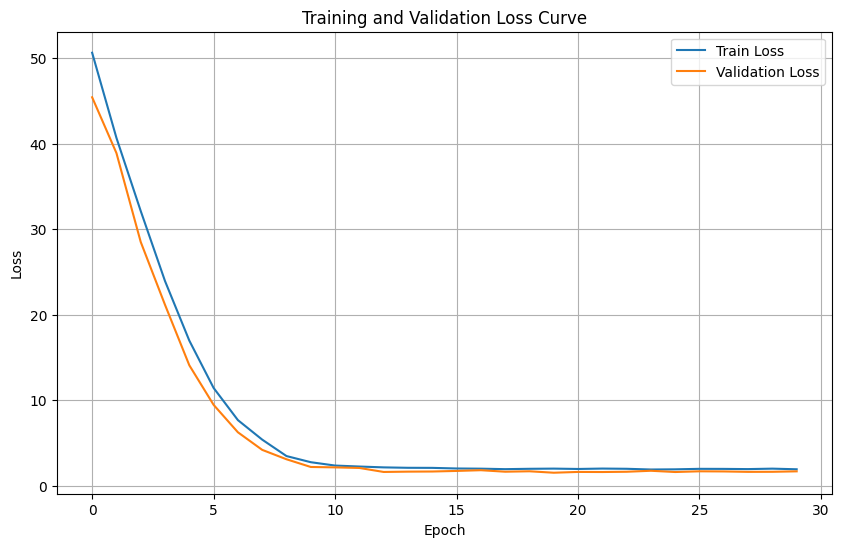

Validation Score: 0.5572
Submission file saved: /content/drive/MyDrive/Contest/New-Medinine-Dev//submission/RDKitCorr45_ChemBERTEmbed_ChemBERT_MLP22.csv


In [79]:
class ChemicalFeatureGenerator():
    """
    ChemBERT 모델을 사용하여 임베딩 벡터와 RDKit 피처를 생성하는 클래스.
    """
    def __init__(self, chembert_model: str) -> None:
        # ChemBERT 모델의 토크나이저 초기화
        self.tokenizer = AutoTokenizer.from_pretrained(chembert_model)

    def get_molecular_features(self, mol: Chem.Mol) -> list:
        """
        RDKit을 사용하여 분자의 다양한 피처를 추출하는 함수.
        pIC50과 상관관계가 높은 5가지 피처와 특정 화학 그룹의 개수를 추출.
        """
        return [
            # pIC50 상관관계 0.45이상 피처 5개
            Descriptors.Chi0(mol),
            Descriptors.Chi0n(mol),
            Descriptors.Chi2n(mol),
            Descriptors.Kappa1(mol),
            Descriptors.fr_pyridine(mol),

            # 특정 화학그룹 존재 유무
            len(mol.GetSubstructMatches(MolFromSmiles("[C](=O)[OH]"))),     # Carboxyl(산성) 그룹(수소 결합 수용체 및 공여체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[NH2]"))),           # Amine(염기) 그룹(수소 결합 공여체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[NH4+]"))),          # Ammonium(양전하 이온) 그룹(강한 수소 결합 공여체, 이온 결합) 개수
            len(mol.GetSubstructMatches(MolFromSmiles("[S](=O)(=O)[O-]"))), # Sulfonic Acid(강한 산성 작용기) 그룹(수소 결합 수용체) 개수
            len(mol.GetSubstructMatches(MolFromSmiles('CO')))               # Alkoxy(에터구조) 그룹(수소 결합 수용체) 개수
        ]

    def encoder_smiles(self, smiles: str) -> torch.Tensor:
        """
        SMILES 문자열을 ChemBERT 모델에 입력할 수 있도록 토큰화하고 텐서 형식으로 변환.
        """
        inputs = self.tokenizer.encode_plus(smiles, padding=True, return_tensors='pt', add_special_tokens=True)
        return inputs['input_ids']

class ChemicalDataset(Dataset):
    """
    PyTorch Dataset 클래스를 확장하여 화학 데이터를 다루는 데이터셋 클래스.
    """
    def __init__(
        self,
        dataframe: pd.DataFrame,
        mol_features: np.array,
        feature_generator,
        is_train = True
    ):
        super().__init__()
        self.df = dataframe
        self.mol_features = mol_features
        self.feature_generator = feature_generator
        self.is_train = is_train

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> tuple:
        """
        데이터셋에서 특정 인덱스의 샘플을 가져오는 함수.
        """
        sample = self.df.iloc[idx]
        molecular_feature = self.mol_features[idx]
        smiles = sample['Smiles']
        input_ids = self.feature_generator.encoder_smiles(smiles)  # ChemBERT 임베딩

        # 라벨 값 설정
        label = sample['pIC50'] if self.is_train else -99.

        # 텐서로 변환
        molecular_feature = torch.tensor(molecular_feature, dtype=torch.float).view(1, -1)
        label = torch.tensor(label, dtype=torch.float).view(1, -1)

        return input_ids, molecular_feature, label


class KFoldDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning을 사용한 K-Fold 데이터 모듈 클래스.
    """
    def __init__(
        self,
        train_df: str,
        feature_generator: ChemicalFeatureGenerator,
        k_idx: int = 1,
        num_splits: int = 5,
        batch_size: int = 32,
        seed: int = 42
    ):
        super().__init__()
        self.train_df = train_df
        self.feature_generator = feature_generator
        self.k_idx = k_idx
        self.num_splits = num_splits
        self.batch_size = batch_size
        self.seed = seed
        self.train_data = None
        self.val_data = None

    def setup(self, stage: str = None) -> None:
        """
        데이터셋 설정 및 구성 함수.
        """
        df = pd.read_csv(self.train_df)

        # RDKit 피처 생성
        mol_features = []
        for smiles in df['Smiles']:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mol_features.append(self.feature_generator.get_molecular_features(mol))

        mol_features = np.array(mol_features)

        # 피처 스케일링
        mol_scaler = StandardScaler()
        mol_features = mol_scaler.fit_transform(mol_features)

        # K-Fold 데이터 분할
        kf = KFold(n_splits=self.num_splits, shuffle=True, random_state=self.seed)
        train_idx, val_idx = list(kf.split(df))[self.k_idx]

        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        self.train_data = ChemicalDataset(
            dataframe=train_df,
            mol_features=mol_features[train_idx],
            feature_generator=self.feature_generator,
            is_train=True
        )
        self.val_data = ChemicalDataset(
            dataframe=val_df,
            mol_features=mol_features[val_idx],
            feature_generator=self.feature_generator,
            is_train=True
        )

    def train_dataloader(self) -> DataLoader:
        """
        학습 데이터셋 로더를 반환하는 함수.
        """
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.custom_collate_fn)

    def val_dataloader(self) -> DataLoader:
        """
        검증 데이터셋 로더를 반환하는 함수.
        """
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.custom_collate_fn)

    @staticmethod
    def custom_collate_fn(batch):
        """
        DataLoader에서 각 샘플의 크기를 맞추기 위한 collate 함수.
        """
        input_ids, molecular_features, labels = zip(*batch)

        # input_ids를 패딩하여 같은 길이로 맞추기
        input_ids = [x.squeeze(0) for x in input_ids]  # 각 텐서의 배치 차원 제거
        input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)

        # molecular_features는 동일한 크기여야 함
        molecular_features = torch.stack(molecular_features, dim=0)

        # labels를 스택
        labels = torch.stack(labels, dim=0)

        return input_ids_padded, molecular_features, labels

class SimplifiedMLPRegressor(nn.Module):
    '''
    ChemBERT 임베딩과 RDKit 피처를 결합하여 회귀 예측을 수행하는 다층 퍼셉트론(MLP) 모델
    '''
    def __init__(
        self,
        chembert_model: str, # 허깅페이스 ChemBERT 모델 이름
        chembert_dim: int,   # ChemBERT 임베딩 차원
        mol_dim: int,        # RDKit 피처 차원
        hidden_dim: int,     # MLP hidden 차원
        output_dim: int,     # 출력 차원 (pIC50 예측)
        dropout_rate: float  # Dropout 비율
    ):
        super(SimplifiedMLPRegressor, self).__init__()
        self.chembert_model = AutoModel.from_pretrained(chembert_model) # ChemBERT 모델 로드
        self.chembert_proj = nn.Linear(chembert_dim, hidden_dim) # ChemBERT 임베딩 차원을 hidden_dim으로 변환
        self.mol_proj = nn.Linear(mol_dim, hidden_dim) # RDKit 피처 차원을 hidden_dim으로 변환

        # MLP 레이어 1
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)
        self.drop1 = nn.Dropout(dropout_rate)

        # MLP 레이어 2 (hidden_dim을 절반으로 축소)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.drop2 = nn.Dropout(dropout_rate)

        # 추가 레이어
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        self.drop3 = nn.Dropout(dropout_rate)

        # 최종 출력 레이어
        self.out = nn.Linear(hidden_dim // 2, output_dim)

        # LeakyReLU 활성화 함수 사용
        self.relu = nn.LeakyReLU(0.1)


    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        mol_features: torch.Tensor
    ) -> torch.Tensor:

        chembert_output = self.chembert_model(input_ids=input_ids, attention_mask=attention_mask) # ChemBERT 임베딩 추출
        chembert_embedding = chembert_output.last_hidden_state[:, 0, :]  # [CLS] 토큰 임베딩 추출 (batch_size, chembert_dim)
        chembert_proj = self.chembert_proj(chembert_embedding)  # ChemBERT 임베딩을 hidden_dim 크기로 변환 (batch_size, hidden_dim)

        mol_proj = self.mol_proj(mol_features)  # RDKit 피처를 hidden_dim 크기로 변환 (batch_size, hidden_dim)
        combined_input = torch.cat([chembert_proj, mol_proj], dim=1)  # ChemBERT 임베딩과 RDKit 피처 결합 (batch_size, hidden_dim * 2)

        # 첫 번째 MLP 레이어
        x = self.fc1(combined_input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)

        # 두 번째 MLP 레이어
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)

        # 세 번째 MLP 레이어
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.drop3(x)

        # 최종 출력
        output = self.out(x)
        return output


def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 500,
    lr: float = 0.0003,
    patience: int = 10
) -> nn.Module:

    """
    MLP 모델을 학습하고 검증 데이터를 사용하여 평가하는 함수.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3, verbose=True)

    train_losses = []
    val_losses = []
    est_val_loss = float('inf')
    patience_counter = 0

    # 모델의 RDKit 입력 크기와 일치하도록 설정
    mol_input_dim = model.mol_proj.in_features

    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        # 학습 단계
        total_train_loss = 0
        model.train()  # 학습 모드
        for batch in train_loader:
            input_ids, mol_features, labels = batch

            # mol_features 차원 확인 및 변환 (필요한 경우 패딩)
            if mol_features.size(-1) != mol_input_dim:
                mol_features = F.pad(mol_features, (0, mol_input_dim - mol_features.size(-1)))

            optimizer.zero_grad()
            output = model(
                input_ids=input_ids.squeeze(1),
                attention_mask=None,
                mol_features=mol_features.squeeze(1)
            )
            loss = criterion(output, labels)  # MSE 손실 계산
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 단계
        total_val_loss = 0
        model.eval()
        true_pIC50 = []
        pred_pIC50 = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, mol_features, labels = batch

                # mol_features 차원 확인 및 변환 (필요한 경우 패딩)
                if mol_features.size(-1) != mol_input_dim:
                    mol_features = F.pad(mol_features, (0, mol_input_dim - mol_features.size(-1)))

                output = model(
                    input_ids=input_ids.squeeze(1),
                    attention_mask=None,
                    mol_features=mol_features.squeeze(1)
                )
                loss = criterion(output, labels)
                total_val_loss += loss.item()

                true_pIC50.extend(labels.view(-1).cpu().numpy())
                pred_pIC50.extend(output.view(-1).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 학습 스케줄러 업데이트
        scheduler.step(avg_val_loss)

        # Early Stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
            best_model = model.state_dict()
        else:
            no_improvement_count += 1

        # 학습 중지 조건
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model)
            break

        # 각 epoch 결과 출력
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 학습 곡선 시각화
    plot_loss_curve(train_losses, val_losses)

    # 검증 데이터에 대한 최종 Score 계산
    score = calculate_score(np.array(true_pIC50), np.array(pred_pIC50))
    print(f"Validation Score: {score:.4f}")

    return model, np.array(true_pIC50), np.array(pred_pIC50)

def evaluate_on_test_set(model, test_loader, submission_save_path: str = './baseline_submit.csv') -> None:
    """
    테스트 데이터 평가 및 제출 파일 생성
    """
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, mol_features, _ = batch

            # mol_features 차원 확인 및 변환
            if mol_features.size(-1) != model.mol_proj.in_features:
                mol_features = F.pad(mol_features, (0, model.mol_proj.in_features - mol_features.size(-1)))

            output = model(
                input_ids=input_ids.squeeze(1),
                attention_mask=None,
                mol_features=mol_features.squeeze(1)
            )
            test_predictions.extend(output.view(-1).cpu().numpy())

    # pIC50 예측값을 IC50 값으로 변환하여 제출 파일 생성
    test_predictions = np.array(test_predictions)
    test_ic50 = pIC50_to_IC50(test_predictions)

    submit = pd.read_csv(f'{ROOT_DIR_GOOGLEDRIVE}/data/original/sample_submission.csv') # 경로
    submit['IC50_nM'] = test_ic50
    submit.to_csv(submission_save_path, index=False)
    print(f"Submission file saved: {submission_save_path}")

if __name__ == "__main__":
    # 데이터 준비
    config = {
        "chembert_model": 'seyonec/ChemBERTa-zinc-base-v1',
        "train_df": f'{ROOT_DIR_GOOGLEDRIVE}/data/original/train.csv', # 경로
        "test_df": f'{ROOT_DIR_GOOGLEDRIVE}/data/original/test.csv',   # 경로
        "batch_size": 32,
        "num_splits": 5,
        "seed": 42
    }

    # Chemical Feature Generator 초기화
    generator = ChemicalFeatureGenerator(config["chembert_model"])

    # K-Fold 방식을 사용하는 KFoldDataModule로 데이터셋 로드
    data_module = KFoldDataModule(
        train_df=config["train_df"],
        feature_generator=generator,
        k_idx=0,
        num_splits=config["num_splits"],
        batch_size=config["batch_size"],
        seed=config["seed"]
    )

    # setup 호출
    data_module.setup(stage='fit')

    # 데이터 로더 생성
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()


    # 분자 피처의 차원 계산
    mol_feature_dim = len(generator.get_molecular_features(Chem.MolFromSmiles('C')))  # RDKit 피처 차원

    # 모델 초기화
    model = SimplifiedMLPRegressor(
        chembert_model = config["chembert_model"],
        chembert_dim   = 768,  # ChemBERT 임베딩 차원
        mol_dim        = mol_feature_dim,  # RDKit 피처 차원
        hidden_dim     = 256,  # MLP hidden 차원
        output_dim     = 1,    # 출력 차원 (pIC50 예측)
        dropout_rate   = 0.3   # Dropout 비율
    )

    # 모델 학습 및 평가
    trained_model, true_pIC50, predicted_pIC50 = train_and_evaluate(
        model, train_loader, val_loader, epochs=500, lr=0.0003, patience=10
    )

    # 테스트 데이터 평가 및 제출 파일 생성
    # 테스트 데이터셋 로드
    test_df = pd.read_csv(config["test_df"])

    # 테스트 피처 생성
    test_features = []
    for smiles in test_df['Smiles']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol_features = generator.get_molecular_features(mol)
            test_features.append(mol_features)

    test_features = np.array(test_features)
    test_features = StandardScaler().fit_transform(test_features)

    # 테스트 데이터셋 준비
    test_dataset = ChemicalDataset(
        dataframe=test_df,
        mol_features=test_features,
        feature_generator=generator,
        is_train=False
    )
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=data_module.custom_collate_fn)

    # 테스트 데이터셋 평가 및 제출 파일 저장
    evaluate_on_test_set(
        trained_model,
        test_loader,
        submission_save_path=f'{ROOT_DIR_GOOGLEDRIVE}/submission/RDKitCorr45_ChemBERTEmbed_ChemBERT_MLP22.csv'
    )